## 0. 옵션코드 별로 데이터프레임 나누기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from sklearn.ensemble import IsolationForest
# 한글 폰트 설정 (예: Malgun Gothic)
plt.rc('font', family='Malgun Gothic')
# 폰트 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df=pd.read_excel('데이터1_반품 처리.xlsx')
df

,판매일,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류
0,2021-01-04,300653145487,1,매출,37735,2096,EA,1입,1,옵티프리 익스프레스 120ml (24),비식품,잡화,의약위생용품
1,2021-01-04,1701000822379,8,매출,37902,2090,EA,5입,1,얼음]칵테일,식품,신선식품,"냉동,냉장,간편식"
2,2021-01-04,1701001025007,2,매출,37806,151,CS,400g*1,1,녹두가루400g,식품,가공식품류,분말류등
3,2021-01-04,1701001065324,6,매출,37676,48,CS,1입,1,메밀가루400g,식품,가공식품류,분말류등
4,2021-01-04,1701001092580,3,매출,37791,2044,CS,1입,1,빙초산<50ml,식품,가공식품류,"설탕,소금,조리료류"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
670337,2023-12-29,78801056225703,1,매출,37791,2044,BX,30입,30,롯데]핫식스캔<250ml>,식품,"생수,음료,건강",NaN
670338,2023-12-29,78801062010577,1,매출,38178,113,BX,12입,12,롯데]꼬깔콘고소한<134g>,식품,"과자,씨리얼,초코릿,빵류",NaN
670339,2023-12-29,78801062521035,3,매출,37735,2096,BX,8입,8,롯데]카스타드<230g>,식품,"과자,씨리얼,초코릿,빵류",NaN
670340,2023-12-29,78801075010953,5,매출,37741,12,BX,2입,2,해표]순창궁고추장<6.5kg>면세,식품,가공식품류,"설탕,소금,조리료류"


In [74]:
# '옵션코드' 값들을 통일
df['옵션코드'] = df['옵션코드'].replace({
    'BOX': 'BX',
    'C/S': 'CS',
    'CS1': 'CS',
    'C/S1': 'CS',
    'BX1': 'BX'
})

# 값별 카운팅 결과 확인
option_counts = df['옵션코드'].value_counts()

print(option_counts)

옵션코드
EA    388304
BX    213876
CS     68162
Name: count, dtype: int64


In [75]:
# 옵션코드가 'EA'인 데이터프레임
df_EA = df[df['옵션코드'] == 'EA']

# 옵션코드가 'BX'인 데이터프레임
df_BX = df[df['옵션코드'] == 'BX']

# 옵션코드가 'CS'인 데이터프레임
df_CS = df[df['옵션코드'] == 'CS']

## 0. 주차별로 집계하기

In [76]:
# '판매일' 칼럼을 날짜 형식으로 변환
df_EA['판매일'] = pd.to_datetime(df_EA['판매일'])

# 1. '판매일'을 인덱스로 설정하여 주별로 그룹화
df_EA.set_index('판매일', inplace=True)

# 2. 주별로 그룹화한 후, '상품 바코드(대한상의)' 별로 다시 그룹화하여 집계
# 주별 첫 번째 날짜를 '판매일'로 추가
df1 = df_EA.resample('W-Mon').apply(lambda x: x.groupby('상품 바코드(대한상의)').agg({
        '판매수량': 'sum',        # 판매수량 합계
        '구분': 'first',           # 첫 번째 값 유지
        '우편번호': 'first',
        '매출처코드': 'first',
        '옵션코드': 'first',
        '규격': 'first',
        '입수': 'first',
        '상품명': 'first',
        '대분류': 'first',
        '중분류': 'first',
        '소분류': 'first'
    }).assign(판매일=x.index[0]))  # 각 그룹에 첫 번째 날짜(판매일)를 추가

# 3. 인덱스에 있는 '판매일'을 일반 칼럼으로 다시 되돌리기
df1 = df1.reset_index()

df1

C:\Users\kookjh\AppData\Local\Temp\ipykernel_11356\2160509279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_EA['판매일'] = pd.to_datetime(df_EA['판매일'])


,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
0,300653145487,1,매출,37735,2096,EA,1입,1,옵티프리 익스프레스 120ml (24),비식품,잡화,의약위생용품,2021-01-04
1,1701000822379,8,매출,37902,2090,EA,5입,1,얼음]칵테일,식품,신선식품,"냉동,냉장,간편식",2021-01-04
2,1701001517274,2,매출,37787,185,EA,6入,1,너구리 컵 6入 XX,식품,"라면,통조림,상온즉석",None,2021-01-04
3,1701001521813,34,매출,37793,29,EA,65g*6,1,신라면 컵 6入 XX,식품,"라면,통조림,상온즉석",None,2021-01-04
4,1701001530617,62,매출,37890,2043,EA,6入,1,육개장 사발 6入 XX,식품,"라면,통조림,상온즉석",None,2021-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238252,8888021300727,29,매출,37676,48,EA,1입,1,건전지]에너자이저<ECR 2032>,비식품,잡화,건전지,2023-12-26
238253,8888021301052,3,매출,37676,48,EA,1개,1,건전지]에너자이저<ECR 2025>,비식품,잡화,건전지,2023-12-26
238254,8888021301243,2,매출,37542,8,EA,1개,1,건전지]에너자이저<ECR 2016>,비식품,잡화,건전지,2023-12-26
238255,9556437004490,2,매출,37694,143,EA,120G*4,1,과자]푸딩혼합<4入>,식품,"과자,씨리얼,초코릿,빵류",None,2023-12-26


In [77]:
# '판매일' 칼럼을 날짜 형식으로 변환
df_BX['판매일'] = pd.to_datetime(df_BX['판매일'])

# 1. '판매일'을 인덱스로 설정하여 주별로 그룹화
df_BX.set_index('판매일', inplace=True)

# 2. 주별로 그룹화한 후, '상품 바코드(대한상의)' 별로 다시 그룹화하여 집계
# 주별 첫 번째 날짜를 '판매일'로 추가
df2 = df_BX.resample('W-Mon').apply(lambda x: x.groupby('상품 바코드(대한상의)').agg({
        '판매수량': 'sum',        # 판매수량 합계
        '구분': 'first',           # 첫 번째 값 유지
        '우편번호': 'first',
        '매출처코드': 'first',
        '옵션코드': 'first',
        '규격': 'first',
        '입수': 'first',
        '상품명': 'first',
        '대분류': 'first',
        '중분류': 'first',
        '소분류': 'first'
    }).assign(판매일=x.index[0]))  # 각 그룹에 첫 번째 날짜(판매일)를 추가

# 3. 인덱스에 있는 '판매일'을 일반 칼럼으로 다시 되돌리기
df2 = df2.reset_index()

df2

C:\Users\kookjh\AppData\Local\Temp\ipykernel_11356\3613650381.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_BX['판매일'] = pd.to_datetime(df_BX['판매일'])


,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
0,1701003341082,1,매출,37903,76,BX,1입,16,간장 삼화 맛<900*16>,식품,가공식품류,"설탕,소금,조리료류",2021-01-04
1,1701003361714,1,매출,37903,76,BX,1입,16,간장 삼화 진<900*16>,식품,가공식품류,"설탕,소금,조리료류",2021-01-04
2,1701004378469,1,매출,37775,10,BX,3000*16,16,오)오징어땅콩<3000*16>XXX,식품,"과자,씨리얼,초코릿,빵류",None,2021-01-04
3,1701004535718,1,매출,37853,2,BX,30입,30,오츠카]데미소다캔오렌지<250ml>,식품,"생수,음료,건강",None,2021-01-04
4,1701005211109,1,매출,37788,75,BX,500ml*20,20,맥콜 <500ml*20>XXX,식품,"생수,음료,건강",None,2021-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100105,78801056225703,3,매출,37559,105,BX,30입,30,롯데]핫식스캔<250ml>,식품,"생수,음료,건강",None,2023-12-26
100106,78801062010577,5,매출,37578,2159,BX,12입,12,롯데]꼬깔콘고소한<134g>,식품,"과자,씨리얼,초코릿,빵류",None,2023-12-26
100107,78801062521035,13,매출,37581,159,BX,8입,8,롯데]카스타드<230g>,식품,"과자,씨리얼,초코릿,빵류",None,2023-12-26
100108,78801075010953,5,매출,37741,12,BX,2입,2,해표]순창궁고추장<6.5kg>면세,식품,가공식품류,"설탕,소금,조리료류",2023-12-26


In [78]:
# '판매일' 칼럼을 날짜 형식으로 변환
df_CS['판매일'] = pd.to_datetime(df_CS['판매일'])

# 1. '판매일'을 인덱스로 설정하여 주별로 그룹화
df_CS.set_index('판매일', inplace=True)

# 2. 주별로 그룹화한 후, '상품 바코드(대한상의)' 별로 다시 그룹화하여 집계
# 주별 첫 번째 날짜를 '판매일'로 추가
df3 = df_CS.resample('W-Mon').apply(lambda x: x.groupby('상품 바코드(대한상의)').agg({
        '판매수량': 'sum',        # 판매수량 합계
        '구분': 'first',           # 첫 번째 값 유지
        '우편번호': 'first',
        '매출처코드': 'first',
        '옵션코드': 'first',
        '규격': 'first',
        '입수': 'first',
        '상품명': 'first',
        '대분류': 'first',
        '중분류': 'first',
        '소분류': 'first'
    }).assign(판매일=x.index[0]))  # 각 그룹에 첫 번째 날짜(판매일)를 추가

# 3. 인덱스에 있는 '판매일'을 일반 칼럼으로 다시 되돌리기
df3 = df3.reset_index()

df3

C:\Users\kookjh\AppData\Local\Temp\ipykernel_11356\2925357498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CS['판매일'] = pd.to_datetime(df_CS['판매일'])


,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
0,1701001025007,2,매출,37806,151,CS,400g*1,1,녹두가루400g,식품,가공식품류,분말류등,2021-01-04
1,1701001065324,6,매출,37676,48,CS,1입,1,메밀가루400g,식품,가공식품류,분말류등,2021-01-04
2,1701001092580,3,매출,37791,2044,CS,1입,1,빙초산<50ml,식품,가공식품류,"설탕,소금,조리료류",2021-01-04
3,1701208399345,31,매출,37616,187,CS,1입,50,잡-생활]마스크<KF94/린>,비식품,잡화,의약위생용품,2021-01-04
4,3300000001999,1,매출,37741,6,CS,53g*12*4,12,뽀로로젤리53g*12XXX,식품,"과자,씨리얼,초코릿,빵류",None,2021-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36236,68801056096078,1,매출,37885,2127,CS,6*4,6,롯데]칸타타콘트라베이스라떼<500ml>,식품,"생수,음료,건강",None,2023-12-26
36237,68801056097914,20,매출,37650,62,CS,CS,6,롯데]레쓰비그란데라떼<500ml>,식품,"생수,음료,건강",None,2023-12-26
36238,68801056102069,3,매출,37853,2,CS,6*4,6,롯데]칸타타콘트라베이스스윗블랙<500ml>,식품,"생수,음료,건강",None,2023-12-26
36239,68801056178781,2,매출,37816,2254,CS,6*4,6,롯데]칸타타콘트라베이스디카페인<500ml>,식품,"생수,음료,건강",None,2023-12-26


## 1. df1(EA) 이상치 파악하기

### 1. IQR 사분위

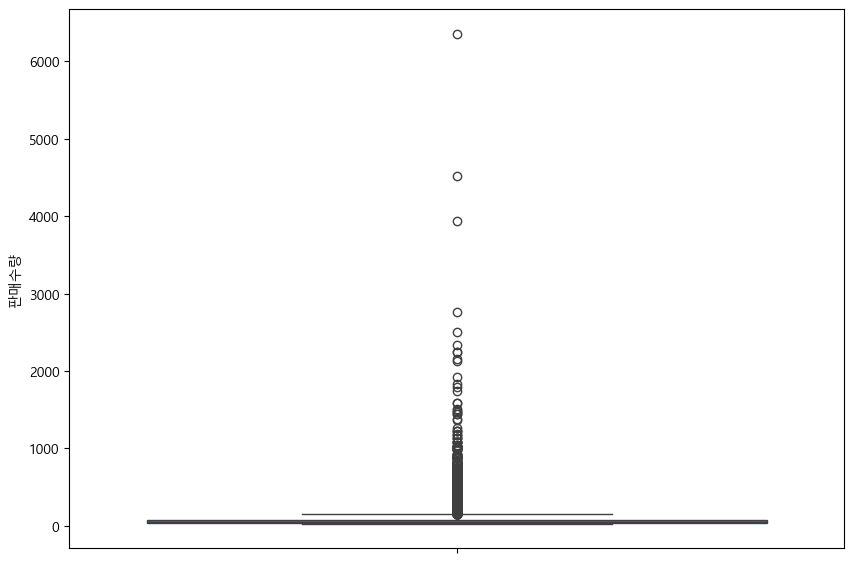

In [79]:
#Q1 Q2의 값을 만들기
Q1 = df1['판매수량'].quantile(0.25)
Q3 = df1['판매수량'].quantile(0.75)

#IQR 만들기
IQR = Q3- Q1

# 이상치 범위 조절
out_range=1.5

# 이상치 범위 설정
outlier_range = (df1['판매수량'] < Q1 - out_range * IQR) | (df1['판매수량'] > Q3 + out_range * IQR)

# 이상치 데이터 선택
df1_outliers1 = df1.loc[outlier_range]

# 이상치만 시각화
plt.figure(figsize=(10,7))
sns.boxplot(y='판매수량', data=df1_outliers1)
plt.show()

In [80]:
#df1(EA)에서 이상치인 행들
df1_outliers1

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
3,1701001521813,34,매출,37793,29,EA,65g*6,1,신라면 컵 6入 XX,식품,"라면,통조림,상온즉석",None,2021-01-04
4,1701001530617,62,매출,37890,2043,EA,6入,1,육개장 사발 6入 XX,식품,"라면,통조림,상온즉석",None,2021-01-04
7,1701001591298,29,매출,37899,100,EA,67g*6,1,새우탕 컵 6入 XX,식품,"라면,통조림,상온즉석",None,2021-01-04
31,1701007143019,68,매출,37791,2044,EA,1입,1,해찬들]쌈장<170g*32>,식품,가공식품류,"설탕,소금,조리료류",2021-01-04
65,4001686301555,43,매출,37890,2043,EA,1입,1,하리보]골드<100g>,식품,"과자,씨리얼,초코릿,빵류",None,2021-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238213,8809437830158,34,매출,37723,2256,EA,20줄,1,잡-종이컵]12온스,비식품,잡화,"일회용제품(용기,젓가락등)",2023-12-26
238215,8809482830004,60,매출,37791,2044,EA,30입,1,참맑은녹차캔<175ml>,식품,"생수,음료,건강",None,2023-12-26
238218,8809527210860,60,매출,37788,75,EA,1입,1,잡-계절]핫팩<행복한/포켓/100g>,비식품,잡화,계절용품,2023-12-26
238219,8809527210884,60,매출,37650,62,EA,1입,1,잡-계절]핫팩<포켓용/미니45g>,비식품,잡화,계절용품,2023-12-26


### 2. Standard Deviation Method

In [81]:
def out_std(df, column):
    global lower, upper #전역 변수로 lower와 upper 지정
    data_mean, data_std = df[column].mean(), df[column].std()
    
    cut_off = data_std *3
    # 평균에 빼고 더해서 , 범위 정하기
    lower, upper = data_mean - cut_off, data_mean +cut_off
    print('lower',lower)
    print('upper',upper)
    
    df_upp = df[df[column]>upper]
    df_low = df[df[column]<lower]
    
    return print('Outlier', df_upp.shape[0] + df_low.shape[0])

In [82]:
out_std(df1, '판매수량')

lower -124.09154591619894
upper 152.35870280980544
Outlier 2325


C:\Users\kookjh\AppData\Local\Temp\ipykernel_11356\1315553468.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['판매수량'], kde=False)


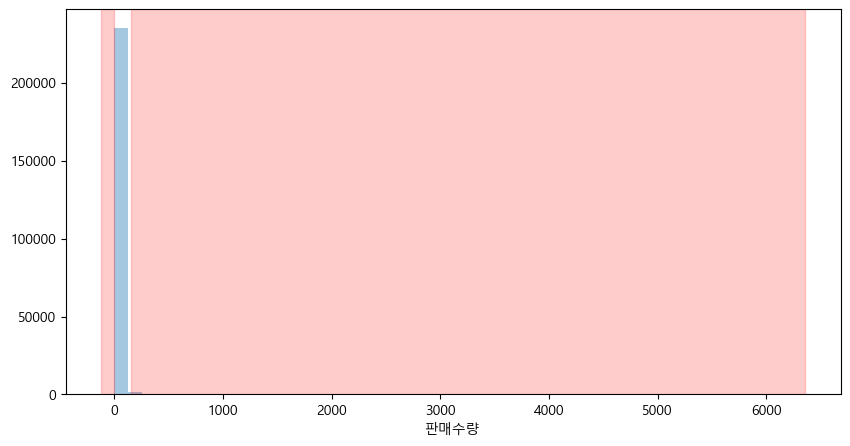

In [83]:
plt.figure(figsize=(10,5))
sns.distplot(df1['판매수량'], kde=False)
plt.axvspan(xmin = lower, xmax = df1['판매수량'].min(), alpha=0.2, color='red')
plt.axvspan(xmin = upper, xmax = df1['판매수량'].max(), alpha=0.2, color='red')

In [84]:
# outlier data
df1_outliers2 = df1[(df1['판매수량']>upper) | (df1['판매수량']< lower)]

In [85]:
#outlier데이터만 추출
df1_outliers2

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
396,8801056290016,240,매출,37816,93,EA,175ml*30,1,롯데]레쓰비<175ml>,식품,"생수,음료,건강",None,2021-01-04
414,8801094013004,180,매출,37789,138,EA,30입,1,코카콜라캔<250ml>,식품,"생수,음료,건강",None,2021-01-04
1393,8801056290016,750,매출,38039,45,EA,175ml*30,1,롯데]레쓰비<175ml>,식품,"생수,음료,건강",None,2021-01-05
1465,8801094503000,330,매출,37933,14,EA,240ml*30,1,조지아캔 오리지널<240ml*30>,식품,"생수,음료,건강",None,2021-01-05
1707,8802280004066,180,매출,37592,2222,EA,1입,1,과자]브이콘대,식품,"과자,씨리얼,초코릿,빵류",None,2021-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
237558,8801094503000,240,매출,37577,111,EA,240ml*30,1,조지아캔 오리지널<240ml*30>,식품,"생수,음료,건강",None,2023-12-26
237565,8801097160064,270,매출,37685,1118,EA,30입,1,오츠카]데미소다캔애플<250ml>,식품,"생수,음료,건강",None,2023-12-26
238113,8809208379909,336,매출,37542,8,EA,8입,1,까스활75ml+속청환1포,비식품,잡화,의약위생용품,2023-12-26
238155,8809267390341,433,매출,37902,2090,EA,30입,1,계란]영양<왕란>,식품,"축산,수산,건해산",None,2023-12-26


### 3. Z-score method

In [86]:
def out_zscore(data):
    global outliers, zscore
    #outlier 변수 담기 
    outliers =[]
    zscore= []
    
    #평균, 분산, threshold 지정
    threshold = 2
    mean = np.mean(data)
    std = np.std(data)
    
    for i in data:
        z_score = (i- mean)/std
        zscore.append(z_score)
        if np.abs(z_score)> threshold:
            outliers.append(i)
    return outliers

In [87]:
outlier_values=out_zscore(df1.판매수량)

C:\Users\kookjh\AppData\Local\Temp\ipykernel_11356\2248039830.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(zscore)


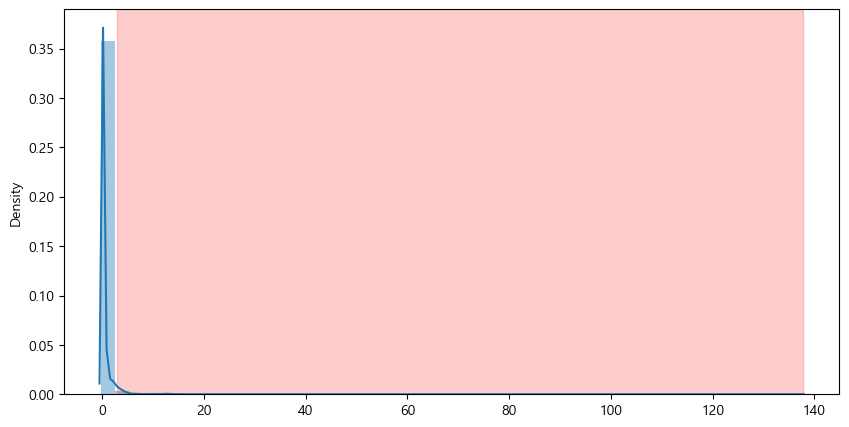

In [88]:
plt.figure(figsize=(10,5))
sns.distplot(zscore)
plt.axvspan(xmin = 3, xmax = max(zscore), alpha=0.2, color='red')

In [89]:
# 이상치인 데이터만 추출
df1_outliers3 = df1[df1['판매수량'].isin(outlier_values)]

df1_outliers3

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
209,8801038560014,120,매출,37742,49,EA,1입,1,잡-면도기]터치3<1입>,비식품,잡화,"면도기,라이타등",2021-01-04
396,8801056290016,240,매출,37816,93,EA,175ml*30,1,롯데]레쓰비<175ml>,식품,"생수,음료,건강",None,2021-01-04
414,8801094013004,180,매출,37789,138,EA,30입,1,코카콜라캔<250ml>,식품,"생수,음료,건강",None,2021-01-04
415,8801094017606,120,매출,37581,159,EA,24입,1,코카콜라<500ml>,식품,"생수,음료,건강",None,2021-01-04
421,8801094503000,120,매출,37890,2043,EA,240ml*30,1,조지아캔 오리지널<240ml*30>,식품,"생수,음료,건강",None,2021-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
237880,8806351807006,120,매출,37925,7,EA,1입,1,잡-장갑]예식<무단추/쌍마/두꺼비>,비식품,잡화,장갑등,2023-12-26
237954,8809010652313,109,매출,37676,48,EA,1입,1,문구]테이프투명<1/2>대한,비식품,잡화,사무용품,2023-12-26
238113,8809208379909,336,매출,37542,8,EA,8입,1,까스활75ml+속청환1포,비식품,잡화,의약위생용품,2023-12-26
238155,8809267390341,433,매출,37902,2090,EA,30입,1,계란]영양<왕란>,식품,"축산,수산,건해산",None,2023-12-26


### 4. Isolation Forest

C:\Users\kookjh\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


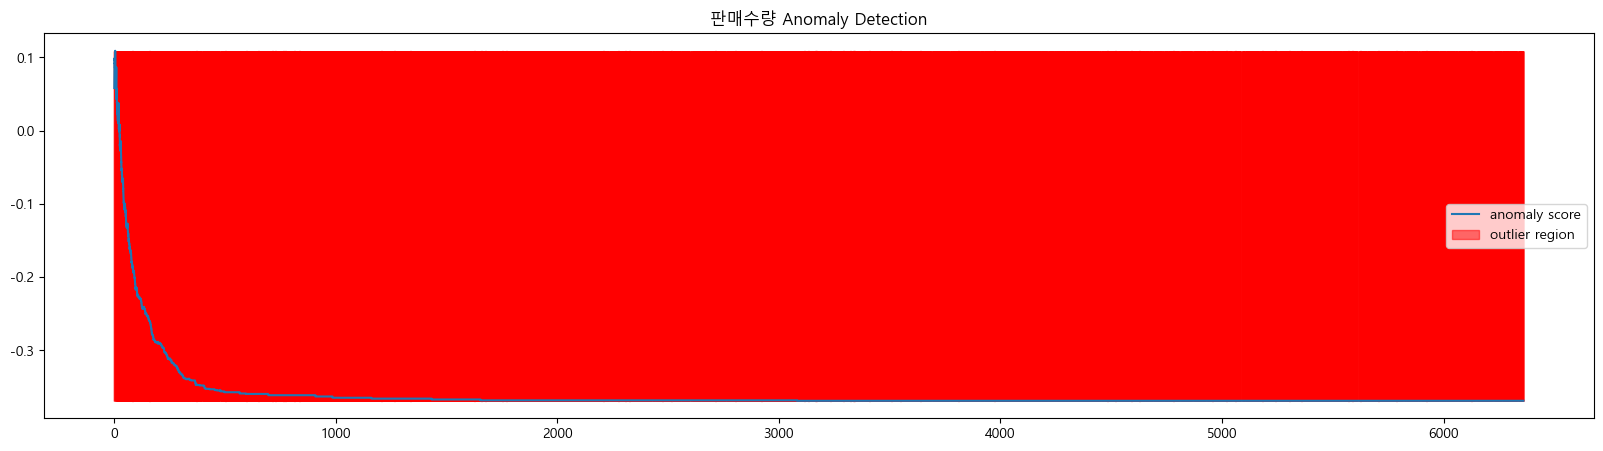

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
3,1701001521813,34,매출,37793,29,EA,65g*6,1,신라면 컵 6入 XX,식품,"라면,통조림,상온즉석",None,2021-01-04
4,1701001530617,62,매출,37890,2043,EA,6入,1,육개장 사발 6入 XX,식품,"라면,통조림,상온즉석",None,2021-01-04
5,1701001554774,25,매출,37787,185,EA,6入,1,김치사발면 6入 XX,식품,"라면,통조림,상온즉석",None,2021-01-04
7,1701001591298,29,매출,37899,100,EA,67g*6,1,새우탕 컵 6入 XX,식품,"라면,통조림,상온즉석",None,2021-01-04
31,1701007143019,68,매출,37791,2044,EA,1입,1,해찬들]쌈장<170g*32>,식품,가공식품류,"설탕,소금,조리료류",2021-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238213,8809437830158,34,매출,37723,2256,EA,20줄,1,잡-종이컵]12온스,비식품,잡화,"일회용제품(용기,젓가락등)",2023-12-26
238215,8809482830004,60,매출,37791,2044,EA,30입,1,참맑은녹차캔<175ml>,식품,"생수,음료,건강",None,2023-12-26
238218,8809527210860,60,매출,37788,75,EA,1입,1,잡-계절]핫팩<행복한/포켓/100g>,비식품,잡화,계절용품,2023-12-26
238219,8809527210884,60,매출,37650,62,EA,1입,1,잡-계절]핫팩<포켓용/미니45g>,비식품,잡화,계절용품,2023-12-26


In [90]:
cols = ['판매수량']

# 그래프를 그리기 위해서 subplot 생성
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', edgecolor='k')

# Isolation Forest 모델 학습
isolation_forest = IsolationForest(contamination='auto')
isolation_forest.fit(df1[cols].values.reshape(-1, 1))

# 이상치 탐지를 위한 예측
outlier = isolation_forest.predict(df1[cols].values.reshape(-1, 1))

# 이상치 점수 계산
xx = np.linspace(df1['판매수량'].min(), df1['판매수량'].max(), len(df1)).reshape(-1, 1)
anomaly_score = isolation_forest.decision_function(xx)

# 그래프 그리기
ax.plot(xx, anomaly_score, label='anomaly score')
ax.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                where=outlier == -1, color='r', alpha=0.5, label='outlier region')
ax.legend()
ax.set_title('판매수량 Anomaly Detection')
plt.show()

# 이상치 데이터 행 출력
df1_outliers4 = df1[outlier == -1]
df1_outliers4

## 공통 이상치만 출력 -> 공통 이상치 제외한 데이터프레임 생성

In [91]:
common_outliers1 = df1_outliers1.merge(df1_outliers2, on=list(df1_outliers1.columns), how='inner') \
                                 .merge(df1_outliers3, on=list(df1_outliers1.columns), how='inner') \
                                 .merge(df1_outliers4, on=list(df1_outliers1.columns), how='inner')

common_outliers1

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
0,8801056290016,240,매출,37816,93,EA,175ml*30,1,롯데]레쓰비<175ml>,식품,"생수,음료,건강",None,2021-01-04
1,8801094013004,180,매출,37789,138,EA,30입,1,코카콜라캔<250ml>,식품,"생수,음료,건강",None,2021-01-04
2,8801056290016,750,매출,38039,45,EA,175ml*30,1,롯데]레쓰비<175ml>,식품,"생수,음료,건강",None,2021-01-05
3,8801094503000,330,매출,37933,14,EA,240ml*30,1,조지아캔 오리지널<240ml*30>,식품,"생수,음료,건강",None,2021-01-05
4,8802280004066,180,매출,37592,2222,EA,1입,1,과자]브이콘대,식품,"과자,씨리얼,초코릿,빵류",None,2021-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,8801094503000,240,매출,37577,111,EA,240ml*30,1,조지아캔 오리지널<240ml*30>,식품,"생수,음료,건강",None,2023-12-26
2321,8801097160064,270,매출,37685,1118,EA,30입,1,오츠카]데미소다캔애플<250ml>,식품,"생수,음료,건강",None,2023-12-26
2322,8809208379909,336,매출,37542,8,EA,8입,1,까스활75ml+속청환1포,비식품,잡화,의약위생용품,2023-12-26
2323,8809267390341,433,매출,37902,2090,EA,30입,1,계란]영양<왕란>,식품,"축산,수산,건해산",None,2023-12-26


In [92]:
# common_outliers1에 포함된 행을 df1에서 제거
df1_cleaned = df1.merge(common_outliers1, on=list(df1.columns), how='left', indicator=True)
df1_cleaned = df1_cleaned[df1_cleaned['_merge'] == 'left_only'].drop(columns=['_merge'])

df1_cleaned

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
0,300653145487,1,매출,37735,2096,EA,1입,1,옵티프리 익스프레스 120ml (24),비식품,잡화,의약위생용품,2021-01-04
1,1701000822379,8,매출,37902,2090,EA,5입,1,얼음]칵테일,식품,신선식품,"냉동,냉장,간편식",2021-01-04
2,1701001517274,2,매출,37787,185,EA,6入,1,너구리 컵 6入 XX,식품,"라면,통조림,상온즉석",None,2021-01-04
3,1701001521813,34,매출,37793,29,EA,65g*6,1,신라면 컵 6入 XX,식품,"라면,통조림,상온즉석",None,2021-01-04
4,1701001530617,62,매출,37890,2043,EA,6入,1,육개장 사발 6入 XX,식품,"라면,통조림,상온즉석",None,2021-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238252,8888021300727,29,매출,37676,48,EA,1입,1,건전지]에너자이저<ECR 2032>,비식품,잡화,건전지,2023-12-26
238253,8888021301052,3,매출,37676,48,EA,1개,1,건전지]에너자이저<ECR 2025>,비식품,잡화,건전지,2023-12-26
238254,8888021301243,2,매출,37542,8,EA,1개,1,건전지]에너자이저<ECR 2016>,비식품,잡화,건전지,2023-12-26
238255,9556437004490,2,매출,37694,143,EA,120G*4,1,과자]푸딩혼합<4入>,식품,"과자,씨리얼,초코릿,빵류",None,2023-12-26


In [93]:
# 엑셀 파일로 저장
df1_cleaned.to_excel('EA 이상치 제외_주 단위.xlsx', index=False)

## 2. df2(BX) 이상치 파악하기

### 1. IQR 사분위

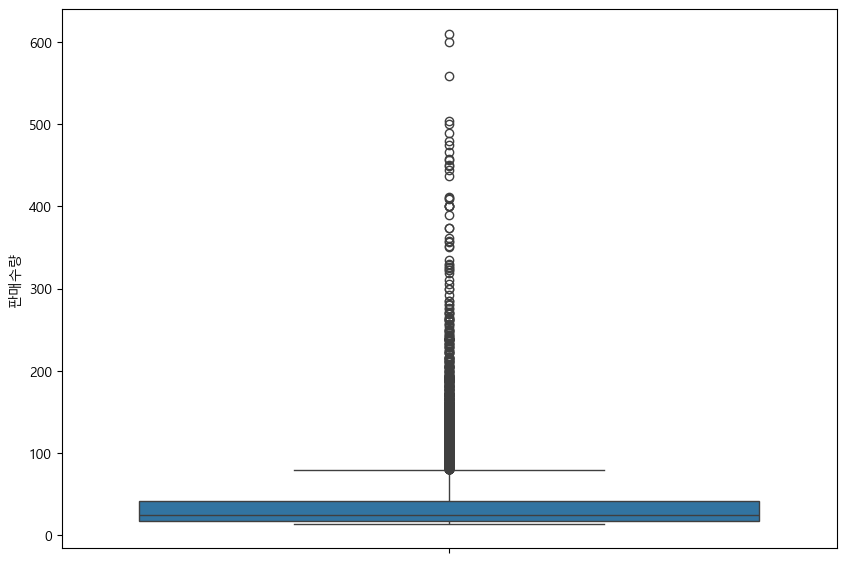

In [94]:
#Q1 Q2의 값을 만들기
Q1 = df2['판매수량'].quantile(0.25)
Q3 = df2['판매수량'].quantile(0.75)

#IQR 만들기
IQR = Q3- Q1

# 이상치 범위 조절
out_range=1.5

# 이상치 범위 설정
outlier_range = (df2['판매수량'] < Q1 - out_range * IQR) | (df2['판매수량'] > Q3 + out_range * IQR)

# 이상치 데이터 선택
df2_outliers1 = df2.loc[outlier_range]

# 이상치만 시각화
plt.figure(figsize=(10,7))
sns.boxplot(y='판매수량', data=df2_outliers1)
plt.show()

In [95]:
#df2(BX)에서 이상치인 행들
df2_outliers1

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
16,1701006174809,14,매출,37575,2141,BX,30입,30,코카콜라캔<250ml>,식품,"생수,음료,건강",None,2021-01-04
38,3300000006178,14,매출,37624,5,BX,120ml*100,100,박카스F 120mlXXXX,식품,"생수,음료,건강",None,2021-01-04
45,8801043014793,20,매출,37575,2141,BX,40입,40,농심]안성탕면멀티<125g>,식품,"라면,통조림,상온즉석",None,2021-01-04
46,8801043014847,16,매출,37544,95,BX,40입,40,농심]신라면멀티<120g>,식품,"라면,통조림,상온즉석",None,2021-01-04
65,8801043020480,20,매출,37611,171,BX,6입,6,농심]백산수<2L>,식품,"생수,음료,건강",None,2021-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99955,18803060080802,15,매출,37650,62,BX,92*30,30,백제쌀국수(멸치),식품,"라면,통조림,상온즉석",None,2023-12-26
100040,28806011615402,98,매출,37608,2183,BX,100입,100,박카스F<120ml>,식품,"생수,음료,건강",None,2023-12-26
100066,58801056190120,14,매출,37728,196,BX,12입,12,롯데]칠성사이다<1.5L>,식품,"생수,음료,건강",None,2023-12-26
100080,68801056042716,15,매출,37867,35,BX,30입,30,롯데]칠성사이다캔<190ml>업소,식품,"생수,음료,건강",None,2023-12-26


### 2. Standard Deviation Method

In [96]:
def out_std(df, column):
    global lower, upper #전역 변수로 lower와 upper 지정
    data_mean, data_std = df[column].mean(), df[column].std()
    
    cut_off = data_std *3
    # 평균에 빼고 더해서 , 범위 정하기
    lower, upper = data_mean - cut_off, data_mean +cut_off
    print('lower',lower)
    print('upper',upper)
    
    df_upp = df[df[column]>upper]
    df_low = df[df[column]<lower]
    
    return print('Outlier', df_upp.shape[0] + df_low.shape[0])

In [97]:
out_std(df2, '판매수량')

lower -46.879440046099674
upper 60.937196513985
Outlier 1626


C:\Users\kookjh\AppData\Local\Temp\ipykernel_11356\3522138605.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df2['판매수량'], kde=False)


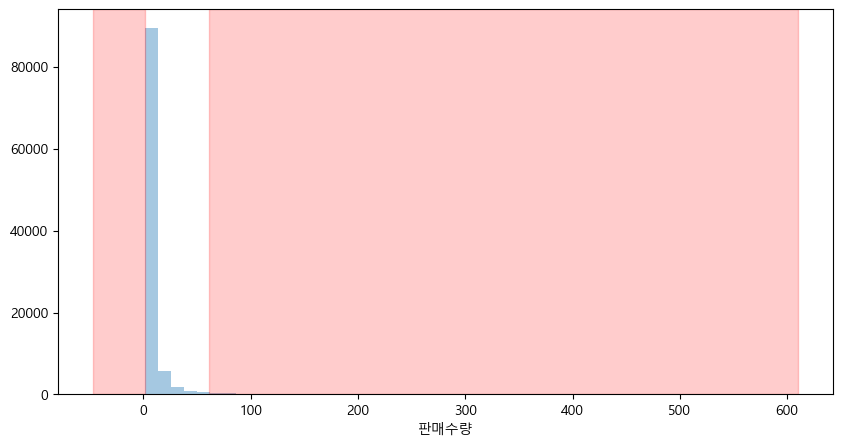

In [98]:
plt.figure(figsize=(10,5))
sns.distplot(df2['판매수량'], kde=False)
plt.axvspan(xmin = lower, xmax = df2['판매수량'].min(), alpha=0.2, color='red')
plt.axvspan(xmin = upper, xmax = df2['판매수량'].max(), alpha=0.2, color='red')

In [99]:
# outlier data
df2_outliers2 = df2[(df2['판매수량']>upper) | (df2['판매수량']< lower)]

In [100]:
#outlier데이터만 추출
df2_outliers2

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
155,18801037047995,118,매출,37544,95,BX,1입,4,맥심모카 210T<*4>XXX,식품,"커피,차류",None,2021-01-04
515,8801045570105,67,매출,37560,2173,BX,6입,6,오뚜기]진라면<순한/작은컵/65g>,식품,"라면,통조림,상온즉석",None,2021-01-05
524,8801056085407,80,매출,37684,98,BX,20입,20,롯데]아이시스8.0<300ml>,식품,"생수,음료,건강",None,2021-01-05
1147,8801056085407,97,매출,37846,126,BX,20입,20,롯데]아이시스8.0<300ml>,식품,"생수,음료,건강",None,2021-01-12
1470,18801551302112,70,매출,38002,167,BX,28입,1,부탄]하이썬,비식품,잡화,야외용품등,2021-01-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99635,8808244101079,247,매출,37577,111,BX,2L*6,6,삼다수2L,식품,"생수,음료,건강",None,2023-12-26
99636,8808244101086,89,매출,37577,111,BX,500ml*20,20,삼다수500ml,식품,"생수,음료,건강",None,2023-12-26
99650,8809336979996,79,매출,37539,23,BX,20줄,1000,종이컵]일반형<한나>,비식품,잡화,"일회용제품(용기,젓가락등)",2023-12-26
99951,18801551302112,90,매출,37577,111,BX,28입,1,부탄]하이썬,비식품,잡화,야외용품등,2023-12-26


### 3. Z-score method

In [101]:
def out_zscore(data):
    global outliers, zscore
    #outlier 변수 담기 
    outliers =[]
    zscore= []
    
    #평균, 분산, threshold 지정
    threshold = 2
    mean = np.mean(data)
    std = np.std(data)
    
    for i in data:
        z_score = (i- mean)/std
        zscore.append(z_score)
        if np.abs(z_score)> threshold:
            outliers.append(i)
    return outliers

In [102]:
outlier_values=out_zscore(df2.판매수량)

C:\Users\kookjh\AppData\Local\Temp\ipykernel_11356\2248039830.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(zscore)


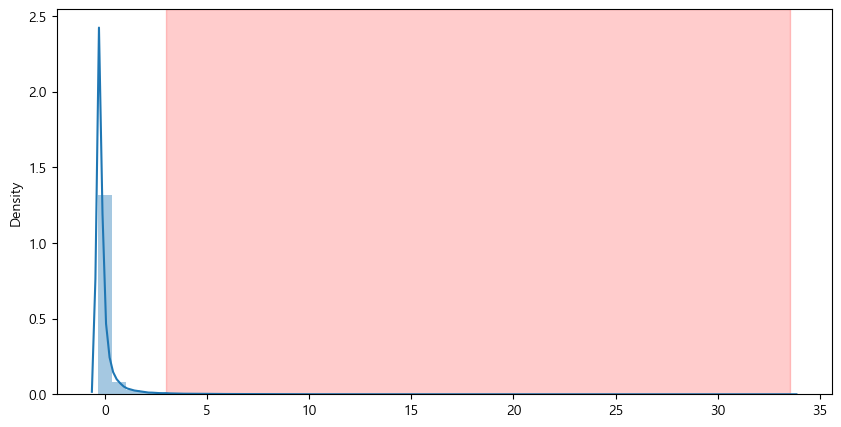

In [103]:
plt.figure(figsize=(10,5))
sns.distplot(zscore)
plt.axvspan(xmin = 3, xmax = max(zscore), alpha=0.2, color='red')

In [104]:
# 이상치인 데이터만 추출
df2_outliers3 = df2[df2['판매수량'].isin(outlier_values)]

df2_outliers3

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
155,18801037047995,118,매출,37544,95,BX,1입,4,맥심모카 210T<*4>XXX,식품,"커피,차류",None,2021-01-04
512,8801043812160,52,매출,37788,75,BX,6입,6,농심]튀김우동컵<6入>,식품,"라면,통조림,상온즉석",None,2021-01-05
515,8801045570105,67,매출,37560,2173,BX,6입,6,오뚜기]진라면<순한/작은컵/65g>,식품,"라면,통조림,상온즉석",None,2021-01-05
524,8801056085407,80,매출,37684,98,BX,20입,20,롯데]아이시스8.0<300ml>,식품,"생수,음료,건강",None,2021-01-05
663,18801045892082,45,매출,37611,171,BX,6입,6,오뚜기]맛있는밥<210g*4>,식품,"라면,통조림,상온즉석",None,2021-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99650,8809336979996,79,매출,37539,23,BX,20줄,1000,종이컵]일반형<한나>,비식품,잡화,"일회용제품(용기,젓가락등)",2023-12-26
99903,18801128505793,57,매출,37545,21,BX,18입,18,팔도]왕뚜껑<110g>,식품,"라면,통조림,상온즉석",None,2023-12-26
99948,18801551102019,53,매출,37577,111,BX,28입,1,부탄]썬연료,비식품,잡화,야외용품등,2023-12-26
99951,18801551302112,90,매출,37577,111,BX,28입,1,부탄]하이썬,비식품,잡화,야외용품등,2023-12-26


### 4. Isolation Forest

C:\Users\kookjh\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


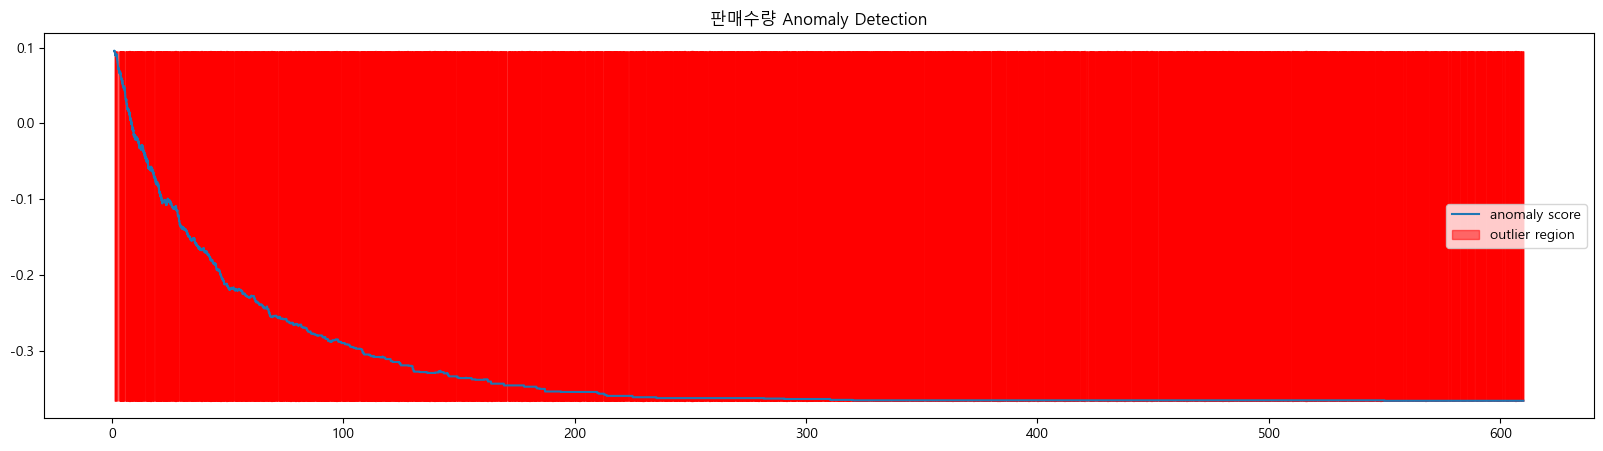

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
16,1701006174809,14,매출,37575,2141,BX,30입,30,코카콜라캔<250ml>,식품,"생수,음료,건강",None,2021-01-04
17,1701006181609,12,매출,37632,99,BX,12입,12,코카콜라<1.5>,식품,"생수,음료,건강",None,2021-01-04
38,3300000006178,14,매출,37624,5,BX,120ml*100,100,박카스F 120mlXXXX,식품,"생수,음료,건강",None,2021-01-04
45,8801043014793,20,매출,37575,2141,BX,40입,40,농심]안성탕면멀티<125g>,식품,"라면,통조림,상온즉석",None,2021-01-04
46,8801043014847,16,매출,37544,95,BX,40입,40,농심]신라면멀티<120g>,식품,"라면,통조림,상온즉석",None,2021-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100066,58801056190120,14,매출,37728,196,BX,12입,12,롯데]칠성사이다<1.5L>,식품,"생수,음료,건강",None,2023-12-26
100080,68801056042716,15,매출,37867,35,BX,30입,30,롯데]칠성사이다캔<190ml>업소,식품,"생수,음료,건강",None,2023-12-26
100100,68801056290308,34,매출,37769,67,BX,175ml*30,30,롯데]레쓰비<175ml>,식품,"생수,음료,건강",None,2023-12-26
100107,78801062521035,13,매출,37581,159,BX,8입,8,롯데]카스타드<230g>,식품,"과자,씨리얼,초코릿,빵류",None,2023-12-26


In [105]:
cols = ['판매수량']

# 그래프를 그리기 위해서 subplot 생성
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', edgecolor='k')

# Isolation Forest 모델 학습
isolation_forest = IsolationForest(contamination='auto')
isolation_forest.fit(df2[cols].values.reshape(-1, 1))

# 이상치 탐지를 위한 예측
outlier = isolation_forest.predict(df2[cols].values.reshape(-1, 1))

# 이상치 점수 계산
xx = np.linspace(df2['판매수량'].min(), df2['판매수량'].max(), len(df2)).reshape(-1, 1)
anomaly_score = isolation_forest.decision_function(xx)

# 그래프 그리기
ax.plot(xx, anomaly_score, label='anomaly score')
ax.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                where=outlier == -1, color='r', alpha=0.5, label='outlier region')
ax.legend()
ax.set_title('판매수량 Anomaly Detection')
plt.show()

# 이상치 데이터 행 출력
df2_outliers4 = df2[outlier == -1]
df2_outliers4

## 공통 이상치만 출력 -> 공통 이상치 제외한 데이터프레임 생성

In [106]:
common_outliers2 = df2_outliers1.merge(df2_outliers2, on=list(df2_outliers1.columns), how='inner') \
                                 .merge(df2_outliers3, on=list(df2_outliers1.columns), how='inner') \
                                 .merge(df2_outliers4, on=list(df2_outliers1.columns), how='inner')

common_outliers2

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
0,18801037047995,118,매출,37544,95,BX,1입,4,맥심모카 210T<*4>XXX,식품,"커피,차류",None,2021-01-04
1,8801045570105,67,매출,37560,2173,BX,6입,6,오뚜기]진라면<순한/작은컵/65g>,식품,"라면,통조림,상온즉석",None,2021-01-05
2,8801056085407,80,매출,37684,98,BX,20입,20,롯데]아이시스8.0<300ml>,식품,"생수,음료,건강",None,2021-01-05
3,8801056085407,97,매출,37846,126,BX,20입,20,롯데]아이시스8.0<300ml>,식품,"생수,음료,건강",None,2021-01-12
4,18801551302112,70,매출,38002,167,BX,28입,1,부탄]하이썬,비식품,잡화,야외용품등,2021-01-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,8808244101079,247,매출,37577,111,BX,2L*6,6,삼다수2L,식품,"생수,음료,건강",None,2023-12-26
1622,8808244101086,89,매출,37577,111,BX,500ml*20,20,삼다수500ml,식품,"생수,음료,건강",None,2023-12-26
1623,8809336979996,79,매출,37539,23,BX,20줄,1000,종이컵]일반형<한나>,비식품,잡화,"일회용제품(용기,젓가락등)",2023-12-26
1624,18801551302112,90,매출,37577,111,BX,28입,1,부탄]하이썬,비식품,잡화,야외용품등,2023-12-26


In [107]:
# common_outliers2에 포함된 행을 df2에서 제거
df2_cleaned = df2.merge(common_outliers2, on=list(df2.columns), how='left', indicator=True)
df2_cleaned = df2_cleaned[df2_cleaned['_merge'] == 'left_only'].drop(columns=['_merge'])

df2_cleaned

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
0,1701003341082,1,매출,37903,76,BX,1입,16,간장 삼화 맛<900*16>,식품,가공식품류,"설탕,소금,조리료류",2021-01-04
1,1701003361714,1,매출,37903,76,BX,1입,16,간장 삼화 진<900*16>,식품,가공식품류,"설탕,소금,조리료류",2021-01-04
2,1701004378469,1,매출,37775,10,BX,3000*16,16,오)오징어땅콩<3000*16>XXX,식품,"과자,씨리얼,초코릿,빵류",None,2021-01-04
3,1701004535718,1,매출,37853,2,BX,30입,30,오츠카]데미소다캔오렌지<250ml>,식품,"생수,음료,건강",None,2021-01-04
4,1701005211109,1,매출,37788,75,BX,500ml*20,20,맥콜 <500ml*20>XXX,식품,"생수,음료,건강",None,2021-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100105,78801056225703,3,매출,37559,105,BX,30입,30,롯데]핫식스캔<250ml>,식품,"생수,음료,건강",None,2023-12-26
100106,78801062010577,5,매출,37578,2159,BX,12입,12,롯데]꼬깔콘고소한<134g>,식품,"과자,씨리얼,초코릿,빵류",None,2023-12-26
100107,78801062521035,13,매출,37581,159,BX,8입,8,롯데]카스타드<230g>,식품,"과자,씨리얼,초코릿,빵류",None,2023-12-26
100108,78801075010953,5,매출,37741,12,BX,2입,2,해표]순창궁고추장<6.5kg>면세,식품,가공식품류,"설탕,소금,조리료류",2023-12-26


In [108]:
# 엑셀 파일로 저장
df2_cleaned.to_excel('BX 이상치 제외_주 단위.xlsx', index=False)

## 3. df3(CS) 이상치 파악하기

### 1. IQR 사분위

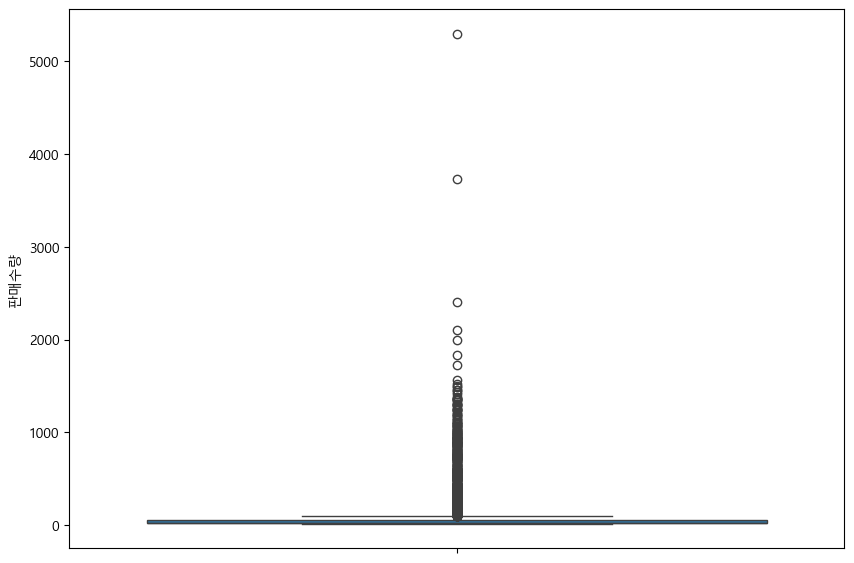

In [109]:
#Q1 Q2의 값을 만들기
Q1 = df3['판매수량'].quantile(0.25)
Q3 = df3['판매수량'].quantile(0.75)

#IQR 만들기
IQR = Q3- Q1

# 이상치 범위 조절
out_range=1.5

# 이상치 범위 설정
outlier_range = (df3['판매수량'] < Q1 - out_range * IQR) | (df3['판매수량'] > Q3 + out_range * IQR)

# 이상치 데이터 선택
df3_outliers1 = df3.loc[outlier_range]

# 이상치만 시각화
plt.figure(figsize=(10,7))
sns.boxplot(y='판매수량', data=df3_outliers1)
plt.show()

In [110]:
#df3(CS)에서 이상치인 행들
df3_outliers1

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
3,1701208399345,31,매출,37616,187,CS,1입,50,잡-생활]마스크<KF94/린>,비식품,잡화,의약위생용품,2021-01-04
6,3300000002927,20,매출,37836,34,CS,12케이스,10,까스활<75ml*10>,식품,"생수,음료,건강",None,2021-01-04
10,3300000004839,108,매출,37692,33,CS,2L*6,6,삼다수2L,식품,"생수,음료,건강",None,2021-01-04
11,3300000004846,53,매출,37692,33,CS,500ml*20,20,삼다수500ml,식품,"생수,음료,건강",None,2021-01-04
61,8809231410624,56,매출,37898,9,CS,1입,1,잡-테이프]스카치<투명/50*100m>,비식품,잡화,"테이프,접착제",2021-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36181,8809274240219,861,매출,37577,111,CS,6입,6,가야산천년수<2L>,식품,"생수,음료,건강",None,2023-12-26
36183,8809296883104,17,매출,37633,2146,CS,32입,4,팔도]짜장면멀티<203g>,식품,"라면,통조림,상온즉석",None,2023-12-26
36185,8809304350079,18,매출,37676,48,CS,1입,10,라이타]터보<하나로>,비식품,잡화,"면도기,라이타등",2023-12-26
36237,68801056097914,20,매출,37650,62,CS,CS,6,롯데]레쓰비그란데라떼<500ml>,식품,"생수,음료,건강",None,2023-12-26


### 2. Standard Deviation Method

In [111]:
def out_std(df, column):
    global lower, upper #전역 변수로 lower와 upper 지정
    data_mean, data_std = df[column].mean(), df[column].std()
    
    cut_off = data_std *3
    # 평균에 빼고 더해서 , 범위 정하기
    lower, upper = data_mean - cut_off, data_mean +cut_off
    print('lower',lower)
    print('upper',upper)
    
    df_upp = df[df[column]>upper]
    df_low = df[df[column]<lower]
    
    return print('Outlier', df_upp.shape[0] + df_low.shape[0])

In [112]:
out_std(df3, '판매수량')

lower -242.52299849661486
upper 271.26381690670286
Outlier 361


C:\Users\kookjh\AppData\Local\Temp\ipykernel_11356\608582794.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df3['판매수량'], kde=False)


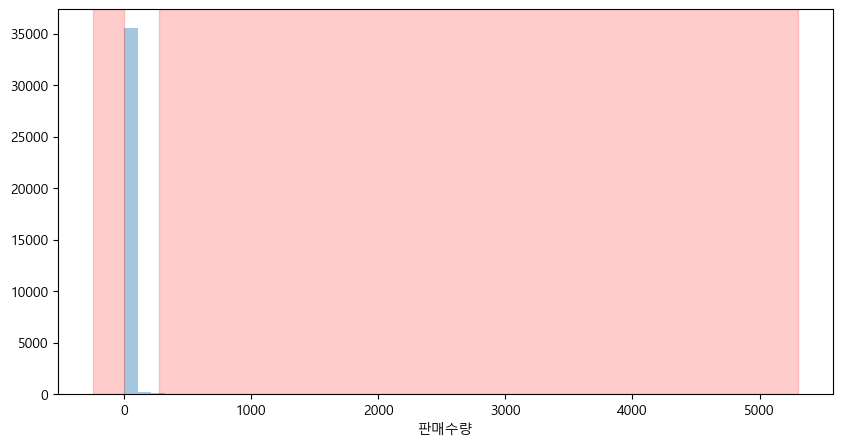

In [113]:
plt.figure(figsize=(10,5))
sns.distplot(df3['판매수량'], kde=False)
plt.axvspan(xmin = lower, xmax = df3['판매수량'].min(), alpha=0.2, color='red')
plt.axvspan(xmin = upper, xmax = df3['판매수량'].max(), alpha=0.2, color='red')

In [114]:
# outlier data
df3_outliers2 = df3[(df3['판매수량']>upper) | (df3['판매수량']< lower)]

In [115]:
#outlier데이터만 추출
df3_outliers2

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
208,8809274240066,348,매출,37542,8,CS,20입,20,가야산천년수<500ml>,식품,"생수,음료,건강",None,2021-01-05
209,8809274240219,800,매출,37542,8,CS,6입,6,가야산천년수<2L>,식품,"생수,음료,건강",None,2021-01-05
388,8809274240219,982,매출,37692,33,CS,6입,6,가야산천년수<2L>,식품,"생수,음료,건강",None,2021-01-12
439,3300000004839,404,매출,37775,10,CS,2L*6,6,삼다수2L,식품,"생수,음료,건강",None,2021-01-19
560,8809274240066,327,매출,37903,76,CS,20입,20,가야산천년수<500ml>,식품,"생수,음료,건강",None,2021-01-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35725,8809274240219,537,매출,37786,2188,CS,6입,6,가야산천년수<2L>,식품,"생수,음료,건강",None,2023-12-12
35950,8809274240066,300,매출,38178,113,CS,20입,20,가야산천년수<500ml>,식품,"생수,음료,건강",None,2023-12-19
35951,8809274240219,416,매출,37902,2090,CS,6입,6,가야산천년수<2L>,식품,"생수,음료,건강",None,2023-12-19
36180,8809274240066,293,매출,37606,38,CS,20입,20,가야산천년수<500ml>,식품,"생수,음료,건강",None,2023-12-26


### 3. Z-score method

In [116]:
def out_zscore(data):
    global outliers, zscore
    #outlier 변수 담기 
    outliers =[]
    zscore= []
    
    #평균, 분산, threshold 지정
    threshold = 2
    mean = np.mean(data)
    std = np.std(data)
    
    for i in data:
        z_score = (i- mean)/std
        zscore.append(z_score)
        if np.abs(z_score)> threshold:
            outliers.append(i)
    return outliers

In [117]:
outlier_values=out_zscore(df3.판매수량)

C:\Users\kookjh\AppData\Local\Temp\ipykernel_11356\2248039830.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(zscore)


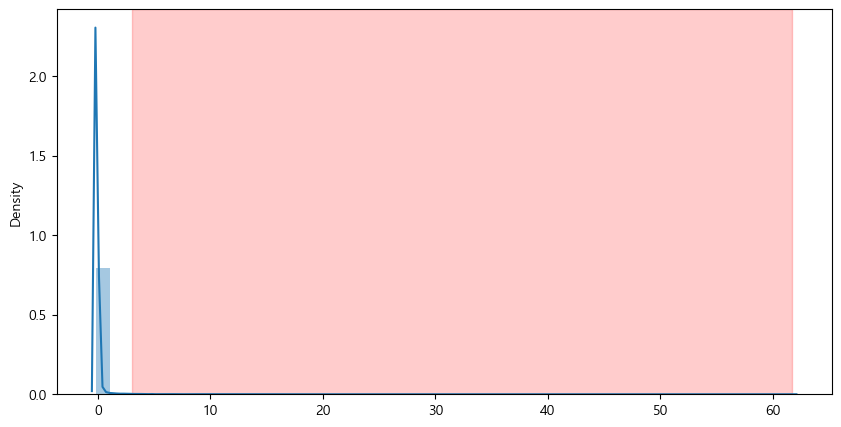

In [118]:
plt.figure(figsize=(10,5))
sns.distplot(zscore)
plt.axvspan(xmin = 3, xmax = max(zscore), alpha=0.2, color='red')

In [119]:
# 이상치인 데이터만 추출
df3_outliers3 = df3[df3['판매수량'].isin(outlier_values)]

df3_outliers3

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
64,8809274240219,258,매출,38178,113,CS,6입,6,가야산천년수<2L>,식품,"생수,음료,건강",None,2021-01-04
93,3300000004839,239,매출,37586,37,CS,2L*6,6,삼다수2L,식품,"생수,음료,건강",None,2021-01-05
208,8809274240066,348,매출,37542,8,CS,20입,20,가야산천년수<500ml>,식품,"생수,음료,건강",None,2021-01-05
209,8809274240219,800,매출,37542,8,CS,6입,6,가야산천년수<2L>,식품,"생수,음료,건강",None,2021-01-05
254,3300000004839,222,매출,37853,2,CS,2L*6,6,삼다수2L,식품,"생수,음료,건강",None,2021-01-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35725,8809274240219,537,매출,37786,2188,CS,6입,6,가야산천년수<2L>,식품,"생수,음료,건강",None,2023-12-12
35950,8809274240066,300,매출,38178,113,CS,20입,20,가야산천년수<500ml>,식품,"생수,음료,건강",None,2023-12-19
35951,8809274240219,416,매출,37902,2090,CS,6입,6,가야산천년수<2L>,식품,"생수,음료,건강",None,2023-12-19
36180,8809274240066,293,매출,37606,38,CS,20입,20,가야산천년수<500ml>,식품,"생수,음료,건강",None,2023-12-26


### 4. Isolation Forest

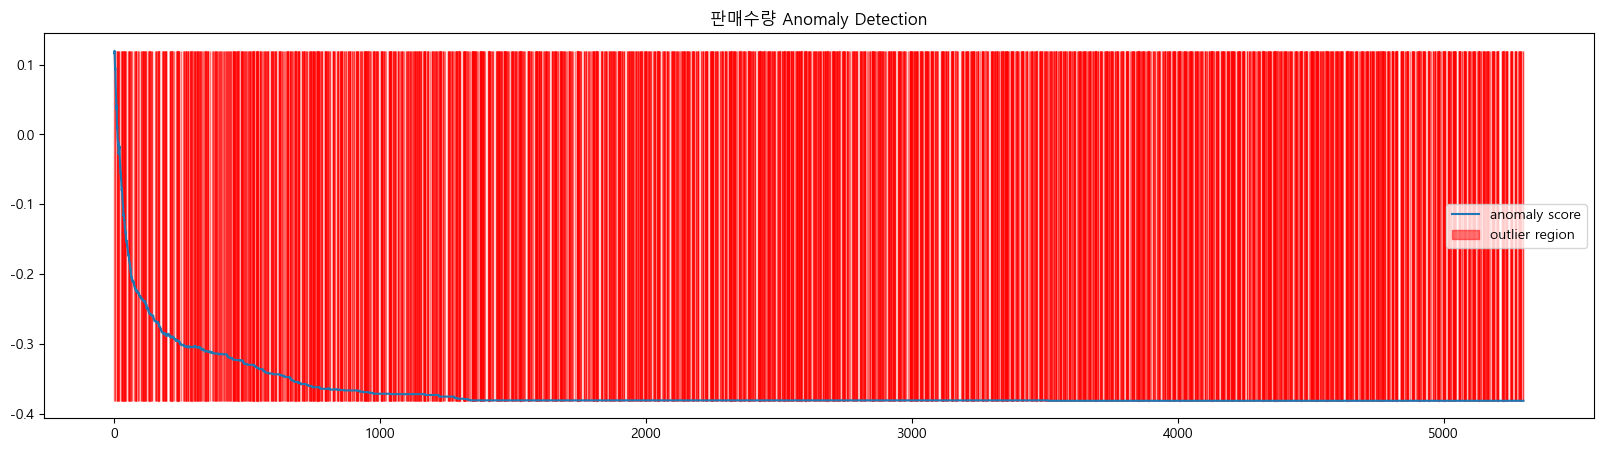

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
3,1701208399345,31,매출,37616,187,CS,1입,50,잡-생활]마스크<KF94/린>,비식품,잡화,의약위생용품,2021-01-04
6,3300000002927,20,매출,37836,34,CS,12케이스,10,까스활<75ml*10>,식품,"생수,음료,건강",None,2021-01-04
10,3300000004839,108,매출,37692,33,CS,2L*6,6,삼다수2L,식품,"생수,음료,건강",None,2021-01-04
11,3300000004846,53,매출,37692,33,CS,500ml*20,20,삼다수500ml,식품,"생수,음료,건강",None,2021-01-04
61,8809231410624,56,매출,37898,9,CS,1입,1,잡-테이프]스카치<투명/50*100m>,비식품,잡화,"테이프,접착제",2021-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36181,8809274240219,861,매출,37577,111,CS,6입,6,가야산천년수<2L>,식품,"생수,음료,건강",None,2023-12-26
36183,8809296883104,17,매출,37633,2146,CS,32입,4,팔도]짜장면멀티<203g>,식품,"라면,통조림,상온즉석",None,2023-12-26
36185,8809304350079,18,매출,37676,48,CS,1입,10,라이타]터보<하나로>,비식품,잡화,"면도기,라이타등",2023-12-26
36237,68801056097914,20,매출,37650,62,CS,CS,6,롯데]레쓰비그란데라떼<500ml>,식품,"생수,음료,건강",None,2023-12-26


In [120]:
cols = ['판매수량']

# 그래프를 그리기 위해서 subplot 생성
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', edgecolor='k')

# Isolation Forest 모델 학습
isolation_forest = IsolationForest(contamination='auto')
isolation_forest.fit(df3[cols].values.reshape(-1, 1))

# 이상치 탐지를 위한 예측
outlier = isolation_forest.predict(df3[cols].values.reshape(-1, 1))

# 이상치 점수 계산
xx = np.linspace(df3['판매수량'].min(), df3['판매수량'].max(), len(df3)).reshape(-1, 1)
anomaly_score = isolation_forest.decision_function(xx)

# 그래프 그리기
ax.plot(xx, anomaly_score, label='anomaly score')
ax.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                where=outlier == -1, color='r', alpha=0.5, label='outlier region')
ax.legend()
ax.set_title('판매수량 Anomaly Detection')
plt.show()

# 이상치 데이터 행 출력
df3_outliers4 = df3[outlier == -1]
df3_outliers4

## 공통 이상치만 출력 -> 공통 이상치 제외한 데이터프레임 생성

In [121]:
common_outliers3 = df3_outliers1.merge(df3_outliers2, on=list(df3_outliers1.columns), how='inner') \
                                 .merge(df3_outliers3, on=list(df3_outliers1.columns), how='inner') \
                                 .merge(df3_outliers4, on=list(df3_outliers1.columns), how='inner')

common_outliers3

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
0,8809274240066,348,매출,37542,8,CS,20입,20,가야산천년수<500ml>,식품,"생수,음료,건강",None,2021-01-05
1,8809274240219,800,매출,37542,8,CS,6입,6,가야산천년수<2L>,식품,"생수,음료,건강",None,2021-01-05
2,8809274240219,982,매출,37692,33,CS,6입,6,가야산천년수<2L>,식품,"생수,음료,건강",None,2021-01-12
3,3300000004839,404,매출,37775,10,CS,2L*6,6,삼다수2L,식품,"생수,음료,건강",None,2021-01-19
4,8809274240066,327,매출,37903,76,CS,20입,20,가야산천년수<500ml>,식품,"생수,음료,건강",None,2021-01-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,8809274240219,537,매출,37786,2188,CS,6입,6,가야산천년수<2L>,식품,"생수,음료,건강",None,2023-12-12
357,8809274240066,300,매출,38178,113,CS,20입,20,가야산천년수<500ml>,식품,"생수,음료,건강",None,2023-12-19
358,8809274240219,416,매출,37902,2090,CS,6입,6,가야산천년수<2L>,식품,"생수,음료,건강",None,2023-12-19
359,8809274240066,293,매출,37606,38,CS,20입,20,가야산천년수<500ml>,식품,"생수,음료,건강",None,2023-12-26


In [122]:
# common_outliers3에 포함된 행을 df3에서 제거
df3_cleaned = df3.merge(common_outliers3, on=list(df3.columns), how='left', indicator=True)
df3_cleaned = df3_cleaned[df3_cleaned['_merge'] == 'left_only'].drop(columns=['_merge'])

df3_cleaned

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
0,1701001025007,2,매출,37806,151,CS,400g*1,1,녹두가루400g,식품,가공식품류,분말류등,2021-01-04
1,1701001065324,6,매출,37676,48,CS,1입,1,메밀가루400g,식품,가공식품류,분말류등,2021-01-04
2,1701001092580,3,매출,37791,2044,CS,1입,1,빙초산<50ml,식품,가공식품류,"설탕,소금,조리료류",2021-01-04
3,1701208399345,31,매출,37616,187,CS,1입,50,잡-생활]마스크<KF94/린>,비식품,잡화,의약위생용품,2021-01-04
4,3300000001999,1,매출,37741,6,CS,53g*12*4,12,뽀로로젤리53g*12XXX,식품,"과자,씨리얼,초코릿,빵류",None,2021-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36236,68801056096078,1,매출,37885,2127,CS,6*4,6,롯데]칸타타콘트라베이스라떼<500ml>,식품,"생수,음료,건강",None,2023-12-26
36237,68801056097914,20,매출,37650,62,CS,CS,6,롯데]레쓰비그란데라떼<500ml>,식품,"생수,음료,건강",None,2023-12-26
36238,68801056102069,3,매출,37853,2,CS,6*4,6,롯데]칸타타콘트라베이스스윗블랙<500ml>,식품,"생수,음료,건강",None,2023-12-26
36239,68801056178781,2,매출,37816,2254,CS,6*4,6,롯데]칸타타콘트라베이스디카페인<500ml>,식품,"생수,음료,건강",None,2023-12-26


In [123]:
# 엑셀 파일로 저장
df3_cleaned.to_excel('CS 이상치 제외_주 단위.xlsx', index=False)

## 최종. 옵션코드별 이상치 처리본 합치기

In [124]:
# '판매일'을 기준으로 데이터프레임 합치기
combined_df = pd.concat([df1_cleaned, df2_cleaned, df3_cleaned]).sort_values(by='판매일')

# 인덱스 초기화
combined_df.reset_index(drop=True, inplace=True)

# 엑셀 파일로 저장
combined_df.to_excel('옵션코드별 이상치 처리 병합_주 단위.xlsx', index=False)

combined_df

,상품 바코드(대한상의),판매수량,구분,우편번호,매출처코드,옵션코드,규격,입수,상품명,대분류,중분류,소분류,판매일
0,300653145487,1,매출,37735,2096,EA,1입,1,옵티프리 익스프레스 120ml (24),비식품,잡화,의약위생용품,2021-01-04
1,8801117344917,1,매출,37676,48,CS,12입,12,오리온]비틀즈<57g>,식품,"과자,씨리얼,초코릿,빵류",None,2021-01-04
2,8801117344115,1,매출,37775,10,CS,6입,6,오리온]아이셔청사과<42g>,식품,"과자,씨리얼,초코릿,빵류",None,2021-01-04
3,8801117342111,1,매출,37676,48,CS,1000*10,10,오)마이구미복숭아1P1000XXX,식품,"과자,씨리얼,초코릿,빵류",None,2021-01-04
4,8801117340810,1,매출,37806,151,CS,1000*12*1,12,오)밀크카라멜<63g*12>XXX,식품,"과자,씨리얼,초코릿,빵류",None,2021-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
370291,4902430311724,10,매출,37867,35,EA,12입,1,다우니]블루용기레몬<1L>,비식품,세제류,세탁,2023-12-26
370292,4902430311670,2,매출,37604,220,EA,1L*1,1,다우니]퍼플용기1L,비식품,세제류,세탁,2023-12-26
370293,4902430311625,8,매출,37604,220,EA,12입,1,다우니]핑크용기베리<1L>,비식품,세제류,세탁,2023-12-26
370294,4902430113304,5,매출,37853,2,EA,24입,1,P&G]페브리즈상쾌한향리필<320ml>,비식품,방향제류,None,2023-12-26
